#Configuration of the notebook and data importation

In [1]:
#Installation of the required package

!pip install scanpy
!pip install scrublet

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2


In [3]:
sc.settings.set_figure_params(dpi=80, color_map="plasma")

In [4]:
#Connexion to the goole drive files
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the dataset

In [5]:
adata =sc.read_text("/content/drive/My Drive/ClinCluster_DataIntegration/GSM3980135_Adult-Fallopian-Tube1_dge.txt", first_column_names = True, delimiter = "\t")
print('Done.')

Done.


In [6]:
#Sparsing the matrix
print(adata.X)
adata.X = sp.sparse.csr_matrix(adata.X)
print('Done.')

[[0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Done.


In [7]:
#Transposing the matrix
adata = adata.T

In [8]:
print(adata)

AnnData object with n_obs × n_vars = 10000 × 24009


In [9]:
#Visualizing adata
adata.obs['lib_prep']= "donor"
print(adata)

AnnData object with n_obs × n_vars = 10000 × 24009
    obs: 'lib_prep'


#Doublet detection and removal

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 9.4 seconds
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Histogram


(<Figure size 640x240 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76d16fbcf8>,
       dtype=object))

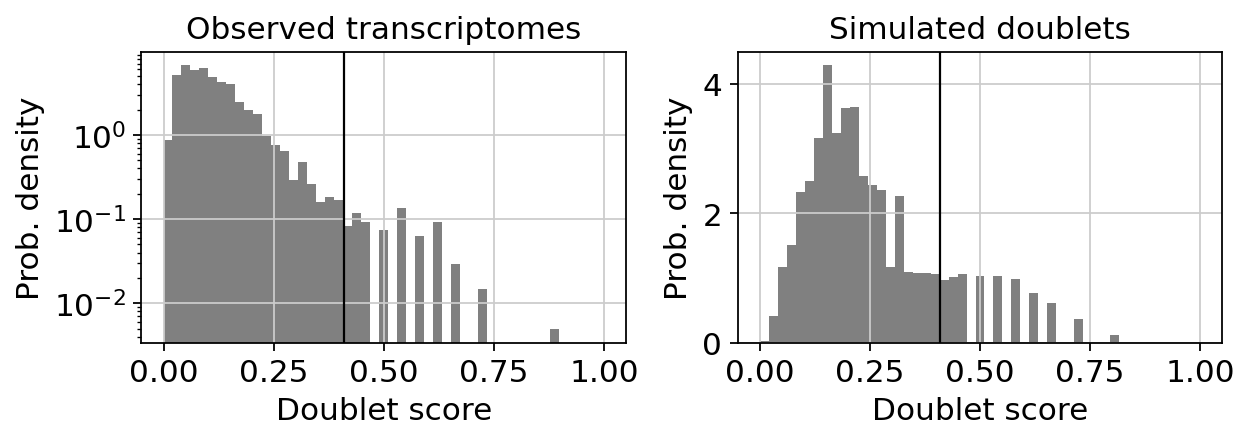

In [10]:
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
predicted_doublet_mask = scrub.call_doublets(threshold=0.41) #threshold adjusted manually
print('Histogram')
scrub.plot_histogram()

Running UMAP...
Done.


/usr/local/lib/python3.6/dist-packages/scrublet/scrublet.py:550: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  cmap=cmap_use, vmin=vmin, vmax=vmax)
/usr/local/lib/python3.6/dist-packages/scrublet/scrublet.py:562: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x[o], y[o], s=marker_size, edgecolors='', c=called_doubs[o], cmap=custom_cmap([[.7,.7,.7], [0,0,0]]))


(<Figure size 640x320 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76c7661240>,
       dtype=object))

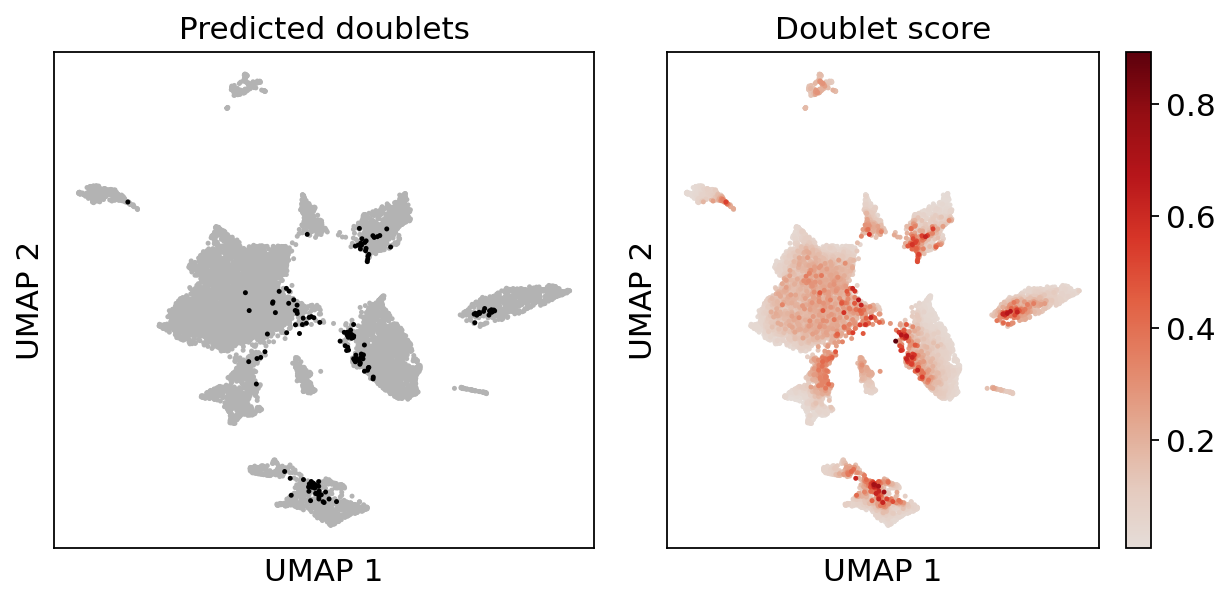

In [11]:
#Visualisation of doublet detection
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
print('Done.')

scrub.plot_embedding('UMAP', order_points=True)

In [12]:
#Filtering out doublets for adata
adata = adata[adata.obs['doublet_scores'] < 0.41, :]

print("Remaining cells {}". format(adata.n_obs))

Remaining cells 9855


#Calculate QC

In [13]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 9855 × 24009
    obs: 'lib_prep', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [14]:
mito_genes = adata.var_names.str.startswith('MT-') #selection of the mitochondrial genes in the adata object
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 #calculating the proportion of mitochondrial genes
adata.obs['n_counts'] = adata.X.sum(axis=1).A1 #add the total counts per cell as observations-annotation to adata

print('Number of mitochodrial genes : {} '.format(sum(mito_genes)))

Number of mitochodrial genes : 36 


In [15]:
ribo_genes = adata.var_names.str.startswith(("RPS","RPL")) #selection of the ribo genes in the adata object
adata.obs['percent_ribo'] = np.sum( adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
print('Number of ribosomial genes : {}'.format(sum(ribo_genes)))

Number of ribosomial genes : 457


In [16]:
adata

AnnData object with n_obs × n_vars = 9855 × 24009
    obs: 'lib_prep', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'lib_prep' as categorical


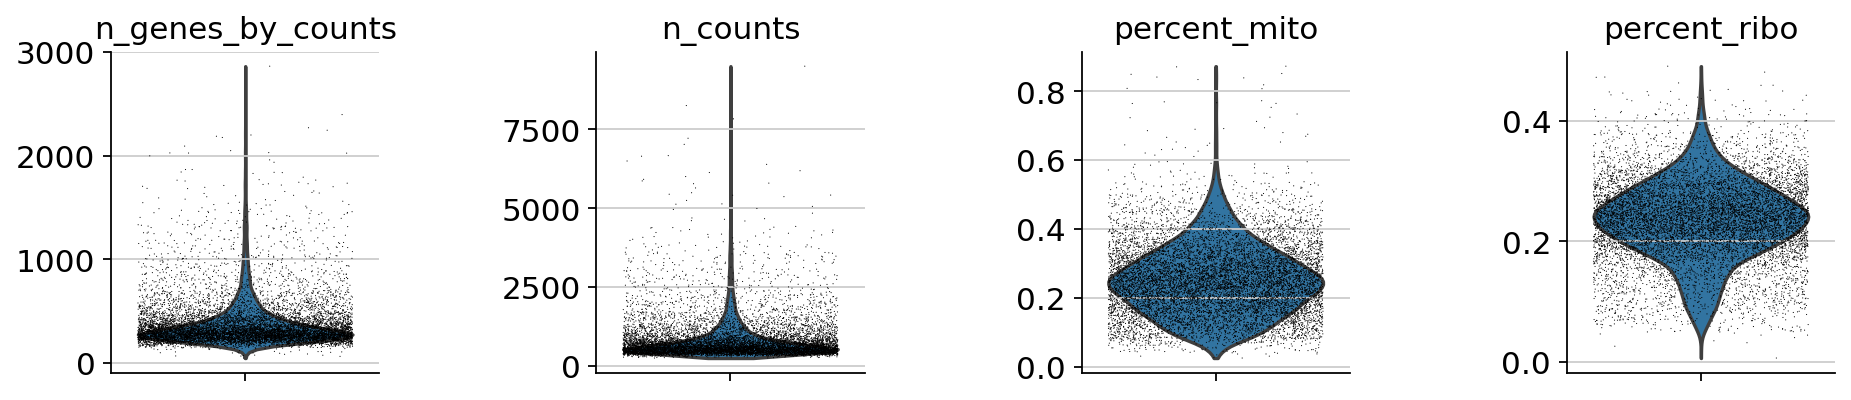

In [17]:
#plot QC : violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'], jitter=0.4, size= 0.5, multi_panel='True')

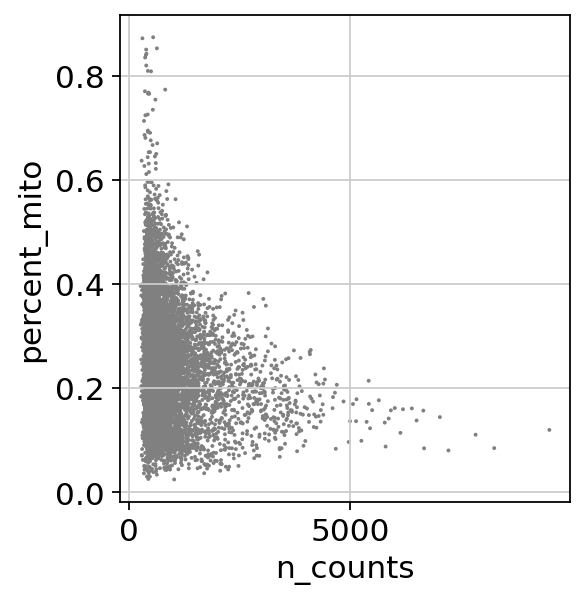

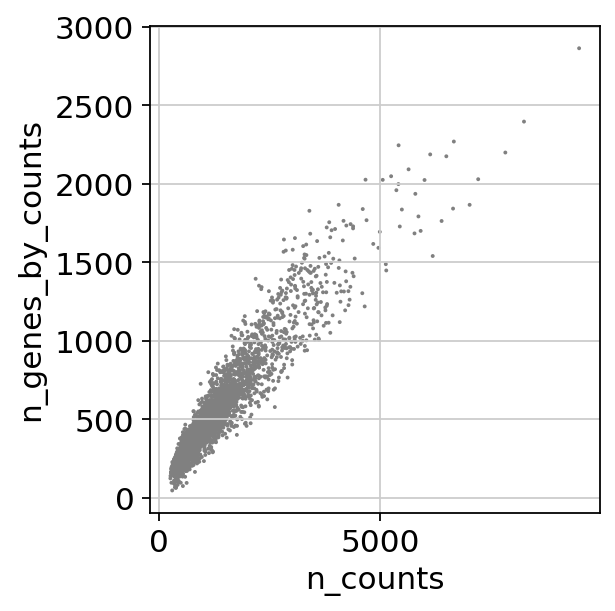

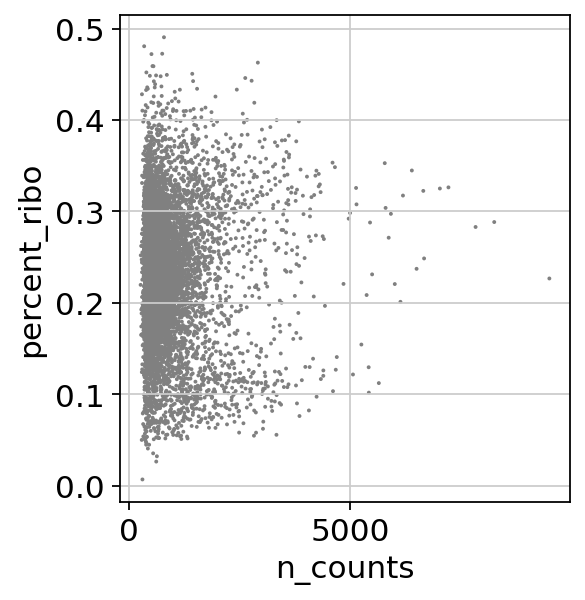

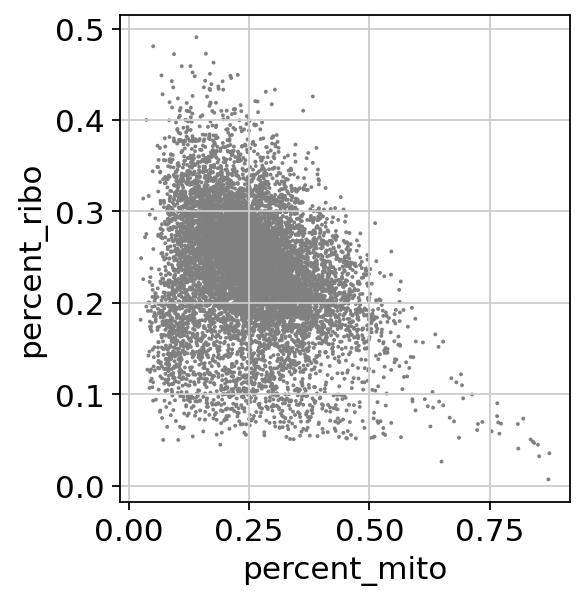

In [18]:
#plot QC : scatter plot

sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')
sc.pl.scatter(adata, x='percent_mito', y='percent_ribo')

#Filtering

In [19]:
#Filter for number of genes per cells

sc.pp.filter_cells(adata, min_genes=200)

print(adata.n_obs, adata.n_vars)

filtered out 608 cells that have less than 200 genes expressed
9247 24009


In [20]:
#Filter for gene detection 
keep = ((adata.obs['n_genes_by_counts'] < 2000) & (adata.obs['n_genes_by_counts'] > 200))
adata = adata[keep,:]

print("Remaining cells {}". format(adata.n_obs))

Remaining cells 9209


In [21]:
#Filtering out mitochondrials and ribosomals genes

# filter for percent mito : mitochondrial genes are an indicator of damaged cells
adata = adata[adata.obs['percent_mito'] < 0.25, :]

# filter for percent ribo
adata = adata[adata.obs['percent_ribo'] > 0.1, :]

print("Remaining cells {}".format(adata.n_obs))

Remaining cells 4952


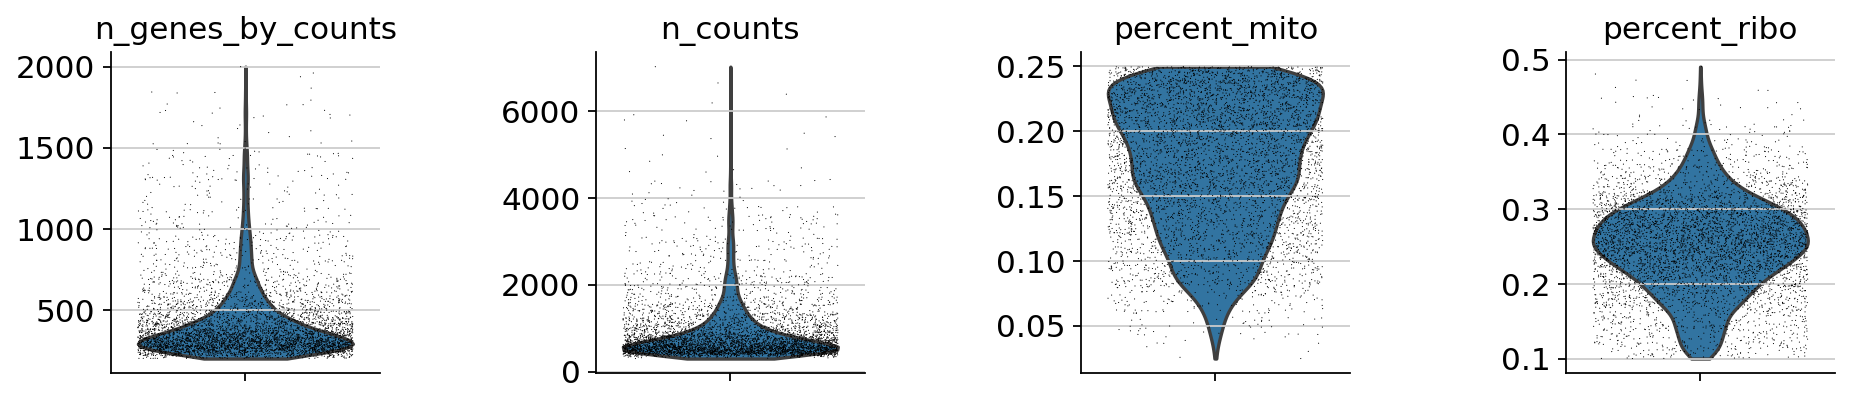

In [22]:
sc.pl.violin(adata, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'], jitter=0.4, size =0.5, multi_panel='True')

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


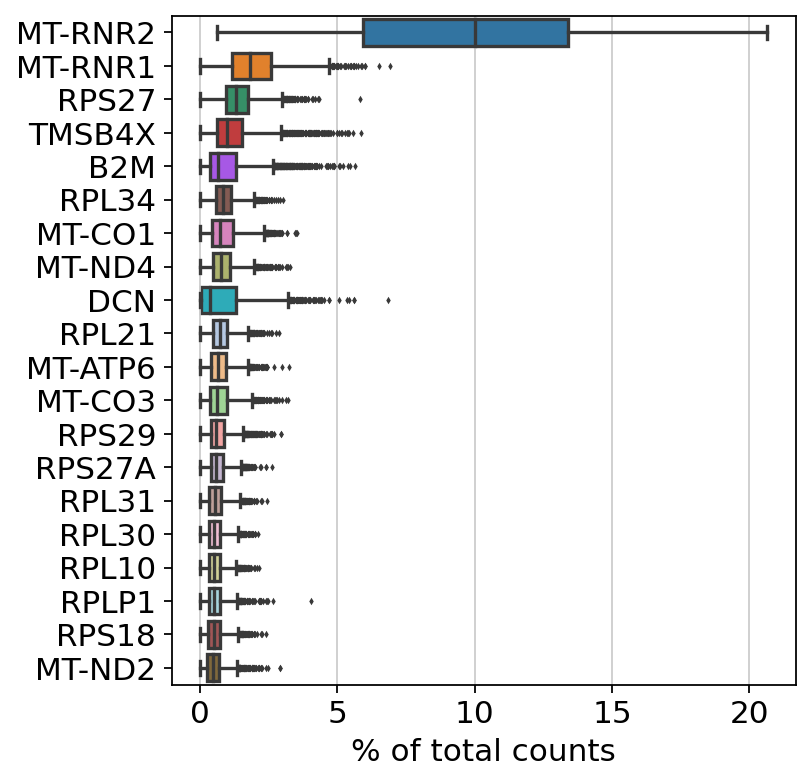

In [23]:
#Highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

Numerous of mitochondrial genes expressed. Particularly MT-RNR2 which counts for about 14% of total counts. We can also emphasize MT-RNR1 which counts for about 4% of total counts. 

In [24]:
MTRNR2 = adata.var_names.str.startswith('MT-RNR2')
keep = np.invert(MTRNR2)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

4952 24008


normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


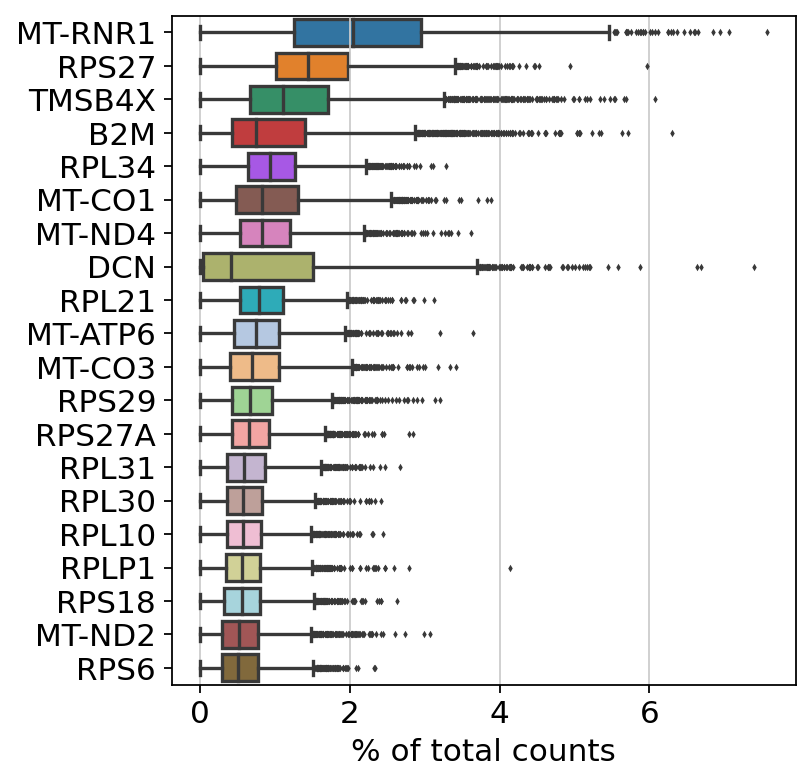

In [25]:
#Highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

In [26]:
adata

AnnData object with n_obs × n_vars = 4952 × 24008
    obs: 'lib_prep', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

#Saving the file

In [27]:
#Saving the file 
from google.colab import files

save_file = '/content/drive/My Drive/ClinCluster_DataIntegration/Notebook_Dataset2/scanpy_QC-filtered.h5ad'
adata.write_h5ad(save_file)
print("Edited.")

Edited.
